In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# GET THE DATAFRAME.

import pandas as pd

# df_path = "../../data/raw/debunking_review.tsv"
df_path = "../../data/raw/hedges-all.tsv"
# df_path = "../../data/raw/studytype_multiclass.tsv"
df = pd.read_csv(df_path, sep="\t")
# df = pd.concat([df * 5])

In [3]:
# PERFORM DATA PROCESSING (LEMATIZATION ETC), GET TFIDF SCORES AND FEATURE NAMES.
# COULD be parallelised
from eppi_text_classification import (
    get_features,
    get_labels,
    get_tfidf_and_names,
)

word_features = get_features(
    df,
    title_key="ti",
    abstract_key="ab",
    # title_key="TI",
    # abstract_key="AB",
)


number of processes: 12
number of processes: 12


In [4]:
labels = get_labels(
    df,
    label_column_name="is_rct",
    positive_class_value="1",
    # label_column_name="Class",
    # positive_class_value="CaseControlStudies",
)
tfidf_scores, feature_names = get_tfidf_and_names(word_features)

In [6]:
# PERFORM AN OPTUNA HYPERPARAMETER SEARCH, CAN CHANGE THE SEARCH SPACE IN OPT.PY

from eppi_text_classification import OptunaHyperparameterOptimisation

# hyperparam_ranges = {
#     "min_child_samples": {"low": 1, "high": 30, "log": False},
#     "learning_rate": {"low": 0.1, "high": 0.6, "log": False},
#     "num_leaves": {"low": 2, "high": 50, "log": False},
#     "n_estimators": {"low": 100, "high": 100, "log": False},
#     "min_split_gain": {"low": 1e-6, "high": 10, "log": False},
#     "min_child_weight": {"low": 1e-6, "high": 1e-1, "log": True},
#     "reg_alpha": {"low": 1e-5, "high": 10, "log": True},
#     "reg_lambda": {"low": 1e-5, "high": 10, "log": True},
#     "linear_tree": {"value": True},
# }

hyperparam_ranges = {
    "min_child_samples": {"low": 1, "high": 30, "log": False, "suggest_type": "int"},
    "learning_rate": {"low": 0.1, "high": 0.6, "log": False, "suggest_type": "float"},
    "num_leaves": {"low": 2, "high": 50, "log": False, "suggest_type": "int"},
    "n_estimators": {"low": 100, "high": 500, "log": False, "suggest_type": "int"},
    "min_split_gain": {"low": 1e-6, "high": 10, "log": False, "suggest_type": "float"},
    "min_child_weight": {
        "low": 1e-6,
        "high": 1e-1,
        "log": True,
        "suggest_type": "float",
    },
    "reg_alpha": {"low": 1e-5, "high": 10, "log": True, "suggest_type": "float"},
    "reg_lambda": {"low": 1e-5, "high": 10, "log": True, "suggest_type": "float"},
}


optimiser = OptunaHyperparameterOptimisation(
    tfidf_scores,
    labels,
    "lightgbm",
    max_n_search_iterations=3000,
    n_jobs=-1,
    nfolds=3,
    num_cv_repeats=1,
    # db_url=f"sqlite:////mnt/tmp/optuna.db", #Use this one on Azure
    db_url=None,
    timeout=10000,
    use_early_terminator=True,
    max_stagnation_iterations=1000,
    wilcoxon_trial_pruner_threshold=None,
    use_worse_than_first_two_pruner=False,
    user_selected_hyperparameter_ranges=hyperparam_ranges,
)

# optimiser.delete_optuna_study("lgbm_hedges")
best_params = optimiser.optimise_hyperparameters(study_name="lgbm_hedges")

[I 2025-02-18 11:42:11,512] A new study created in RDB with name: lgbm_hedges


Number of processes: 12
sqlite:////Users/sjmolyneux/Documents/EPPI_Classification_Public/eppi_text_classification/optuna.db
final ranges: {'max_depth': {'low': 1, 'high': 15, 'log': False, 'suggest_type': 'int'}, 'min_child_samples': {'low': 1, 'high': 30, 'log': False, 'suggest_type': 'int'}, 'num_leaves': {'low': 2, 'high': 50, 'log': False, 'suggest_type': 'int'}, 'n_estimators': {'low': 100, 'high': 500, 'log': False, 'suggest_type': 'int'}, 'learning_rate': {'low': 0.1, 'high': 0.6, 'log': False, 'suggest_type': 'float'}, 'min_split_gain': {'low': 1e-06, 'high': 10, 'log': False, 'suggest_type': 'float'}, 'min_child_weight': {'low': 1e-06, 'high': 0.1, 'log': True, 'suggest_type': 'float'}, 'reg_alpha': {'low': 1e-05, 'high': 10, 'log': True, 'suggest_type': 'float'}, 'reg_lambda': {'low': 1e-05, 'high': 10, 'log': True, 'suggest_type': 'float'}, 'data_sample_strategy': {'value': 'bagging', 'suggest_type': 'singular'}, 'boosting_type': {'value': 'gbdt', 'suggest_type': 'singular'}

/Users/sjmolyneux/Documents/EPPI_Classification_Public/eppi_text_classification/eppi_text_classification/single_process_opt.py:404: ExperimentalWarning: BestValueStagnationEvaluator is experimental (supported from v3.4.0). The interface can change in the future.
  improvement_evaluator=BestValueStagnationEvaluator(
/Users/sjmolyneux/Documents/EPPI_Classification_Public/eppi_text_classification/eppi_text_classification/single_process_opt.py:407: ExperimentalWarning: StaticErrorEvaluator is experimental (supported from v3.2.0). The interface can change in the future.
  error_evaluator=StaticErrorEvaluator(constant=0),
/Users/sjmolyneux/Documents/EPPI_Classification_Public/eppi_text_classification/eppi_text_classification/single_process_opt.py:403: ExperimentalWarning: Terminator is experimental (supported from v3.2.0). The interface can change in the future.
  terminator = Terminator(
/Users/sjmolyneux/Documents/EPPI_Classification_Public/eppi_text_classification/eppi_text_classification

Finished trial with scores: [0.5543203607091722, 0.8700618655393131, 0.6122080356284643]


[I 2025-02-18 11:43:01,361] Trial 4 finished with value: 0.67886342062565 and parameters: {'min_split_gain': 1.90655878334003, 'num_leaves': 40, 'reg_lambda': 0.0004203858816713521, 'min_child_samples': 29, 'learning_rate': 0.4708405324024306, 'max_depth': 8, 'min_child_weight': 0.004587648217829232, 'reg_alpha': 0.0018875049210250248, 'n_estimators': 161}. Best is trial 4 with value: 0.67886342062565.


Finished trial with scores: [0.9738294100580305, 0.9808803314063934, 0.9796502452971756]


[I 2025-02-18 11:43:11,074] Trial 9 finished with value: 0.9781199955871998 and parameters: {'num_leaves': 14, 'min_child_samples': 29, 'min_child_weight': 0.0003162166349254009, 'max_depth': 5, 'reg_alpha': 1.9173139624528476e-05, 'min_split_gain': 9.487132517723277, 'n_estimators': 236, 'reg_lambda': 2.8788191773074755e-05, 'learning_rate': 0.10715413155759915}. Best is trial 9 with value: 0.9781199955871998.


Finished trial with scores: [0.9547607272473404, 0.9688923365558978, 0.9663186223571195]


[I 2025-02-18 11:43:13,710] Trial 0 finished with value: 0.9633238953867859 and parameters: {'min_split_gain': 9.633343019748292, 'max_depth': 8, 'n_estimators': 315, 'num_leaves': 30, 'reg_lambda': 0.487873747727154, 'reg_alpha': 0.016867947461833652, 'min_child_weight': 0.06582027203994156, 'min_child_samples': 26, 'learning_rate': 0.2700952978561275}. Best is trial 9 with value: 0.9781199955871998.


Finished trial with scores: [0.9744793144163529, 0.9825626829256919, 0.979517841250956]


[I 2025-02-18 11:43:31,228] Trial 6 finished with value: 0.9788532795310002 and parameters: {'min_split_gain': 0.10751586720323858, 'reg_lambda': 3.0082188661900844, 'min_child_weight': 4.122800202098202e-05, 'reg_alpha': 0.025130314846815015, 'n_estimators': 435, 'learning_rate': 0.2921878854671167, 'min_child_samples': 20, 'num_leaves': 18, 'max_depth': 1}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9663367713172276, 0.9718088070199473, 0.9728063608457983]


[I 2025-02-18 11:43:38,622] Trial 1 finished with value: 0.9703173130609911 and parameters: {'min_split_gain': 8.240041295023573, 'reg_lambda': 0.7470468323369702, 'reg_alpha': 0.1925338422006773, 'n_estimators': 125, 'num_leaves': 28, 'learning_rate': 0.2736748532838821, 'min_child_weight': 0.0012704427473331714, 'min_child_samples': 16, 'max_depth': 3}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.8309884654976877, 0.9070070126072958, 0.889382725761153]


[I 2025-02-18 11:43:43,961] Trial 2 finished with value: 0.8757927346220454 and parameters: {'reg_alpha': 3.880612886919891, 'min_child_samples': 15, 'reg_lambda': 0.2283515439839905, 'learning_rate': 0.5491342140490169, 'max_depth': 4, 'n_estimators': 162, 'num_leaves': 45, 'min_child_weight': 7.364365149764483e-06, 'min_split_gain': 1.8760212449380356}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9648312262995309, 0.9576201151525562, 0.9431350624086323]


[I 2025-02-18 11:43:52,758] Trial 3 finished with value: 0.9551954679535731 and parameters: {'min_child_weight': 0.05326213003922341, 'max_depth': 12, 'num_leaves': 11, 'learning_rate': 0.3050466468530362, 'reg_lambda': 0.3846071288704193, 'min_child_samples': 20, 'n_estimators': 460, 'reg_alpha': 1.835507525007109e-05, 'min_split_gain': 1.0132511018112986}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.8519794258917163, 0.8900368161584169, 0.8434970425180177]


[I 2025-02-18 11:44:17,898] Trial 14 finished with value: 0.861837761522717 and parameters: {'min_split_gain': 4.629652469991799, 'max_depth': 2, 'n_estimators': 334, 'num_leaves': 27, 'reg_lambda': 0.5586244797051992, 'reg_alpha': 3.387901242922267e-05, 'min_child_weight': 0.019479826852267935, 'min_child_samples': 24, 'learning_rate': 0.36167022970015983}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.8262877914931327, 0.9168771548665959, 0.7372503571023802]


[I 2025-02-18 11:44:24,256] Trial 15 finished with value: 0.8268051011540362 and parameters: {'min_split_gain': 0.1903154986947538, 'reg_lambda': 0.0005735391833435575, 'min_child_weight': 2.421692232810454e-06, 'reg_alpha': 2.1521229296709705e-05, 'n_estimators': 349, 'learning_rate': 0.5704342359279198, 'min_child_samples': 28, 'num_leaves': 23, 'max_depth': 11}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.8167085610807885, 0.8274938174508137, 0.7918835542578033]


[I 2025-02-18 11:44:52,196] Trial 16 finished with value: 0.8120286442631351 and parameters: {'min_split_gain': 6.22432597220102, 'reg_lambda': 4.652246393913584, 'reg_alpha': 0.005384667297983596, 'n_estimators': 119, 'num_leaves': 14, 'learning_rate': 0.398436366073205, 'min_child_weight': 1.5265820562760839e-06, 'min_child_samples': 19, 'max_depth': 11}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9709883124805666, 0.9817789483587539, 0.9784162874072813]


[I 2025-02-18 11:45:02,295] Trial 5 finished with value: 0.9770611827488672 and parameters: {'max_depth': 14, 'reg_alpha': 0.0019443586519604845, 'min_split_gain': 0.970848973149308, 'min_child_weight': 0.002385118516450449, 'reg_lambda': 1.0149314081107432, 'n_estimators': 478, 'min_child_samples': 13, 'num_leaves': 40, 'learning_rate': 0.14136389862655155}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9655137663407044, 0.9730946887876825, 0.9741345258584205]


[I 2025-02-18 11:45:35,650] Trial 17 finished with value: 0.9709143269956025 and parameters: {'reg_alpha': 6.390616699365669e-05, 'min_child_samples': 14, 'reg_lambda': 0.0011650374610943765, 'learning_rate': 0.21904639699470432, 'max_depth': 10, 'n_estimators': 127, 'num_leaves': 18, 'min_child_weight': 0.0002561330198056884, 'min_split_gain': 4.987606760147066}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9597057504670907, 0.9618502615098461, 0.967130321925345]


[I 2025-02-18 11:45:42,302] Trial 20 finished with value: 0.9628954446340939 and parameters: {'min_split_gain': 5.950521031126902, 'reg_lambda': 6.468781501037789, 'min_child_weight': 0.0010410466782347892, 'reg_alpha': 0.07715386984397586, 'n_estimators': 267, 'learning_rate': 0.2975042149345374, 'min_child_samples': 18, 'num_leaves': 24, 'max_depth': 10}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9696112181633236, 0.9781383363237421, 0.9772635652279119]


[I 2025-02-18 11:46:44,664] Trial 10 finished with value: 0.9750043732383259 and parameters: {'num_leaves': 17, 'min_child_weight': 2.9531642392495786e-06, 'min_child_samples': 6, 'reg_alpha': 0.0034975647955197125, 'reg_lambda': 0.03198292675698092, 'min_split_gain': 5.985946341160581, 'learning_rate': 0.1874544045025506, 'n_estimators': 352, 'max_depth': 9}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.7935328031050999, 0.8185747722346131, 0.8367216614693347]


[I 2025-02-18 11:47:10,368] Trial 7 finished with value: 0.8162764122696826 and parameters: {'reg_alpha': 7.639960966011946, 'min_child_samples': 8, 'reg_lambda': 0.00014113223898548264, 'learning_rate': 0.5093716441260125, 'max_depth': 2, 'n_estimators': 450, 'num_leaves': 27, 'min_child_weight': 0.00036171868891594547, 'min_split_gain': 4.425097306954871}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.7458710780546312, 0.7489477383172922, 0.7769483180681132]


[I 2025-02-18 11:47:12,255] Trial 11 finished with value: 0.7572557114800121 and parameters: {'reg_lambda': 1.1469971226915248, 'min_split_gain': 3.858757977586588, 'learning_rate': 0.3762879897846483, 'min_child_samples': 5, 'num_leaves': 25, 'min_child_weight': 0.009266793938287988, 'n_estimators': 499, 'max_depth': 13, 'reg_alpha': 7.022853648052453}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9560979534318692, 0.9624216250489983, 0.9673654810756063]


[I 2025-02-18 11:47:42,057] Trial 8 finished with value: 0.9619616865188245 and parameters: {'reg_lambda': 1.4445707110880477e-05, 'n_estimators': 179, 'min_child_weight': 0.006130188701065667, 'max_depth': 2, 'learning_rate': 0.1881569021323091, 'min_child_samples': 1, 'reg_alpha': 0.0001228091624368267, 'min_split_gain': 8.209306651367156, 'num_leaves': 28}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9736231358061616, 0.9795471099668299, 0.9782761722450515]


[I 2025-02-18 11:47:43,538] Trial 25 finished with value: 0.9771488060060142 and parameters: {'num_leaves': 3, 'min_child_weight': 5.096849499878811e-05, 'min_child_samples': 23, 'reg_alpha': 0.0001947102618347539, 'reg_lambda': 1.1775067480257288e-05, 'min_split_gain': 3.3032314618518948, 'learning_rate': 0.11036238332512499, 'n_estimators': 239, 'max_depth': 5}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9556699238990867, 0.9829265767667171, 0.9414097450334434]


[I 2025-02-18 11:47:46,788] Trial 13 finished with value: 0.9600020818997491 and parameters: {'num_leaves': 9, 'min_child_samples': 8, 'min_child_weight': 0.04785174250274723, 'max_depth': 1, 'reg_alpha': 0.0029386941709496775, 'min_split_gain': 5.998685893824982, 'n_estimators': 498, 'reg_lambda': 3.9134404497437654, 'learning_rate': 0.3500844377875524}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9714671484793266, 0.976665307444271, 0.9739887917434391]


[I 2025-02-18 11:47:59,494] Trial 27 finished with value: 0.9740404158890122 and parameters: {'reg_lambda': 1.303758582265019e-05, 'min_split_gain': 7.9486358132778046, 'learning_rate': 0.10954721615798667, 'min_child_samples': 25, 'num_leaves': 2, 'min_child_weight': 3.565330322478157e-05, 'n_estimators': 249, 'max_depth': 4, 'reg_alpha': 0.0002609674761584853}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.908456849829356, 0.894149629465455, 0.9056821719476055]


[I 2025-02-18 11:48:14,583] Trial 19 finished with value: 0.9027628837474722 and parameters: {'min_split_gain': 4.370381162620019, 'max_depth': 10, 'n_estimators': 283, 'num_leaves': 3, 'reg_lambda': 7.353477185301673e-05, 'reg_alpha': 8.224109562282413, 'min_child_weight': 1.455315502044357e-06, 'min_child_samples': 9, 'learning_rate': 0.3609942112438683}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.896924857954087, 0.8754526108964688, 0.9177006336744078]


[I 2025-02-18 11:48:15,511] Trial 18 finished with value: 0.8966927008416544 and parameters: {'min_child_weight': 0.003191322809182695, 'max_depth': 9, 'num_leaves': 35, 'learning_rate': 0.5182304618166691, 'reg_lambda': 0.002372721079061242, 'min_child_samples': 8, 'n_estimators': 360, 'reg_alpha': 0.7462398723880234, 'min_split_gain': 9.355602172973219}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.7298361987582421, 0.8934690619106076, 0.7522368811799514]


[I 2025-02-18 11:48:22,036] Trial 12 finished with value: 0.7918473806162671 and parameters: {'min_split_gain': 3.833041698776615, 'num_leaves': 17, 'reg_lambda': 0.006402864118481139, 'min_child_samples': 5, 'learning_rate': 0.375271121269524, 'max_depth': 7, 'min_child_weight': 0.0001302358678055044, 'reg_alpha': 0.49560929212929017, 'n_estimators': 472}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9737130931370984, 0.9278758581660396, 0.8754391749560166]


[I 2025-02-18 11:48:32,062] Trial 30 finished with value: 0.9256760420863849 and parameters: {'num_leaves': 2, 'min_child_samples': 30, 'min_child_weight': 3.956349003982768e-05, 'max_depth': 6, 'reg_alpha': 0.5423156509883506, 'min_split_gain': 7.614311634932933, 'n_estimators': 387, 'reg_lambda': 0.010544210247022793, 'learning_rate': 0.4373043750105111}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9744954529408396, 0.98131254500108, 0.9792828614289737]


[I 2025-02-18 11:48:33,749] Trial 21 finished with value: 0.9783636197902977 and parameters: {'min_split_gain': 3.644005483611971, 'reg_lambda': 0.014038370660524855, 'reg_alpha': 0.2638950224888106, 'n_estimators': 482, 'num_leaves': 2, 'learning_rate': 0.1621457036331156, 'min_child_weight': 3.868070256145254e-05, 'min_child_samples': 7, 'max_depth': 15}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.7880269960455832, 0.8322732713637901, 0.81103975970967]


[I 2025-02-18 11:48:37,002] Trial 29 finished with value: 0.8104466757063479 and parameters: {'num_leaves': 6, 'min_child_weight': 3.272357212564161e-05, 'min_child_samples': 30, 'reg_alpha': 0.00045689801202702945, 'reg_lambda': 0.009285634796637295, 'min_split_gain': 9.727725733202353, 'learning_rate': 0.44384255566558195, 'n_estimators': 390, 'max_depth': 6}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9719351656894492, 0.9770847895363066, 0.9749867536177688]


[I 2025-02-18 11:48:44,045] Trial 22 finished with value: 0.9746689029478416 and parameters: {'max_depth': 5, 'reg_alpha': 0.16005135518794103, 'min_split_gain': 3.9603332432512484, 'min_child_weight': 5.730915339103115e-05, 'reg_lambda': 1.2623844378980377e-05, 'n_estimators': 251, 'min_child_samples': 6, 'num_leaves': 2, 'learning_rate': 0.11655587489751595}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.6109929412484786, 0.8682022891122221, 0.8568326704563115]


[I 2025-02-18 11:48:51,771] Trial 31 finished with value: 0.7786759669390041 and parameters: {'reg_lambda': 0.015108030072018774, 'min_split_gain': 9.734528302447968, 'learning_rate': 0.4532806891463901, 'min_child_samples': 30, 'num_leaves': 34, 'min_child_weight': 4.698853760143347e-05, 'n_estimators': 417, 'max_depth': 6, 'reg_alpha': 0.6335460303993332}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9748179245690147, 0.9809198409052302, 0.9794657164977714]


[I 2025-02-18 11:48:55,954] Trial 28 finished with value: 0.9784011606573388 and parameters: {'reg_lambda': 0.012913508900441776, 'n_estimators': 240, 'min_child_weight': 3.762402136475754e-05, 'max_depth': 4, 'learning_rate': 0.10692516368568528, 'min_child_samples': 22, 'reg_alpha': 0.00042904982722748327, 'min_split_gain': 3.0646689118293935, 'num_leaves': 5}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.975110151406855, 0.9815379463930816, 0.9790360459405577]


[I 2025-02-18 11:49:27,259] Trial 24 finished with value: 0.9785613812468315 and parameters: {'min_split_gain': 3.4349071243132245, 'reg_lambda': 1.715455449680553e-05, 'min_child_weight': 6.863122491893863e-05, 'reg_alpha': 1.0113467954170083, 'n_estimators': 242, 'learning_rate': 0.10331812168664722, 'min_child_samples': 6, 'num_leaves': 6, 'max_depth': 5}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9749259929107645, 0.9805316197328487, 0.9794775521642054]


[I 2025-02-18 11:49:31,112] Trial 32 finished with value: 0.9783117216026062 and parameters: {'min_split_gain': 2.5088581469465585, 'max_depth': 6, 'n_estimators': 225, 'num_leaves': 7, 'reg_lambda': 0.009626437860240644, 'reg_alpha': 0.000500301602876669, 'min_child_weight': 5.4387669908724596e-05, 'min_child_samples': 23, 'learning_rate': 0.10224771831769162}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9751065052957673, 0.9805513445961108, 0.9797794214343679]


[I 2025-02-18 11:49:35,527] Trial 34 finished with value: 0.978479090442082 and parameters: {'min_split_gain': 2.7623031945685788, 'num_leaves': 7, 'reg_lambda': 0.04210933846748995, 'min_child_samples': 22, 'learning_rate': 0.10615788960152307, 'max_depth': 6, 'min_child_weight': 4.296576031362704e-05, 'reg_alpha': 0.00035141731079822713, 'n_estimators': 230}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9726621165591184, 0.9793032987024506, 0.9795256719191521]


[I 2025-02-18 11:49:36,416] Trial 33 finished with value: 0.9771636957269071 and parameters: {'min_child_weight': 4.669971299784554e-05, 'max_depth': 6, 'num_leaves': 9, 'learning_rate': 0.12465400308660571, 'reg_lambda': 0.01937033511764093, 'min_child_samples': 22, 'n_estimators': 222, 'reg_alpha': 0.0005710590032820534, 'min_split_gain': 3.08946828241373}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9733084943509784, 0.9802974915831617, 0.9799221069686013]


[I 2025-02-18 11:49:50,362] Trial 35 finished with value: 0.9778426976342471 and parameters: {'num_leaves': 8, 'min_child_samples': 22, 'min_child_weight': 2.9541141978402563e-05, 'max_depth': 5, 'reg_alpha': 0.00034095312949761187, 'min_split_gain': 3.0931713996274217, 'n_estimators': 229, 'reg_lambda': 4.777896867674493e-05, 'learning_rate': 0.10649626107903741}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9727968433524281, 0.9756390766038376, 0.977583427102098]


[I 2025-02-18 11:50:13,218] Trial 36 finished with value: 0.9753397823527878 and parameters: {'min_split_gain': 2.5782642681348276, 'reg_lambda': 0.08231450698770416, 'reg_alpha': 0.02185784026106795, 'n_estimators': 431, 'num_leaves': 8, 'learning_rate': 0.16073663971746427, 'min_child_weight': 1.5255017422268879e-05, 'min_child_samples': 22, 'max_depth': 15}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.971673841137386, 0.9760201250986692, 0.9773179614726343]


[I 2025-02-18 11:50:13,937] Trial 37 finished with value: 0.9750039759028964 and parameters: {'num_leaves': 9, 'min_child_weight': 1.464012435897749e-05, 'min_child_samples': 22, 'reg_alpha': 0.0290564631616695, 'reg_lambda': 0.12323811263348762, 'min_split_gain': 2.3846162263927315, 'learning_rate': 0.15899144126693177, 'n_estimators': 426, 'max_depth': 15}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9722686951955133, 0.9788867454537477, 0.9772230968128822]


[I 2025-02-18 11:50:16,600] Trial 38 finished with value: 0.9761261791540478 and parameters: {'max_depth': 15, 'reg_alpha': 0.015586692724227195, 'min_split_gain': 2.112222372422667, 'min_child_weight': 1.0675492146645992e-05, 'reg_lambda': 0.102030510681361, 'n_estimators': 420, 'min_child_samples': 22, 'num_leaves': 20, 'learning_rate': 0.16586643792954484}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9708555581735829, 0.9786740755643971, 0.978098697024633]


[I 2025-02-18 11:50:21,394] Trial 39 finished with value: 0.9758761102542044 and parameters: {'reg_lambda': 0.096675655229444, 'min_split_gain': 2.70598442486828, 'learning_rate': 0.16049423794883416, 'min_child_samples': 22, 'num_leaves': 20, 'min_child_weight': 1.2633188329396285e-05, 'n_estimators': 438, 'max_depth': 15, 'reg_alpha': 0.035405644580989284}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9713430611577156, 0.9796151906312398, 0.976960918868539]


[I 2025-02-18 11:50:23,972] Trial 41 finished with value: 0.9759730568858315 and parameters: {'min_split_gain': 2.905595960957945, 'reg_lambda': 0.03597700273360548, 'min_child_weight': 1.3563715361314604e-05, 'reg_alpha': 0.02992183978220826, 'n_estimators': 211, 'learning_rate': 0.23265509181981114, 'min_child_samples': 22, 'num_leaves': 7, 'max_depth': 1}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9721627786570286, 0.9740840401110474, 0.9753076914616307]


[I 2025-02-18 11:50:31,886] Trial 40 finished with value: 0.9738515034099021 and parameters: {'reg_lambda': 0.08014977920746327, 'n_estimators': 426, 'min_child_weight': 1.0412328338204491e-05, 'max_depth': 15, 'learning_rate': 0.2152112249796296, 'min_child_samples': 21, 'reg_alpha': 0.02567905974700435, 'min_split_gain': 2.621007005783496, 'num_leaves': 8}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9702933995706196, 0.9766376328633914, 0.9749334931188154]


[I 2025-02-18 11:50:44,685] Trial 43 finished with value: 0.9739548418509422 and parameters: {'min_split_gain': 2.915845011635261, 'num_leaves': 12, 'reg_lambda': 0.0854007601270998, 'min_child_samples': 21, 'learning_rate': 0.21330047820103168, 'max_depth': 3, 'min_child_weight': 1.2475135529074235e-05, 'reg_alpha': 0.017293379887643092, 'n_estimators': 203}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9667372458137564, 0.9721367777009107, 0.97361124593941]


[I 2025-02-18 11:50:53,224] Trial 44 finished with value: 0.970828423151359 and parameters: {'min_child_weight': 1.1058163490378523e-05, 'max_depth': 3, 'num_leaves': 13, 'learning_rate': 0.23782711768931736, 'reg_lambda': 0.08251239732699507, 'min_child_samples': 20, 'n_estimators': 299, 'reg_alpha': 0.029722903154230124, 'min_split_gain': 2.7772664114951433}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9744745924036323, 0.980364615890565, 0.9767133262909126]


[I 2025-02-18 11:50:58,988] Trial 23 finished with value: 0.9771841781950367 and parameters: {'reg_alpha': 0.3387961859427884, 'min_child_samples': 4, 'reg_lambda': 1.0066208154777404e-05, 'learning_rate': 0.11715845462859625, 'max_depth': 5, 'n_estimators': 250, 'num_leaves': 4, 'min_child_weight': 5.540907476073502e-05, 'min_split_gain': 7.260455444153411}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9674797972570963, 0.9721378536025432, 0.9726025243683222]


[I 2025-02-18 11:51:25,459] Trial 45 finished with value: 0.9707400584093206 and parameters: {'num_leaves': 12, 'min_child_samples': 17, 'min_child_weight': 1.1027482910570025e-05, 'max_depth': 3, 'reg_alpha': 0.03477688312603627, 'min_split_gain': 2.2696973680027206, 'n_estimators': 311, 'reg_lambda': 0.09135179183614059, 'learning_rate': 0.23391289847137284}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9677699918362974, 0.9686618545172985, 0.9707296795953589]


[I 2025-02-18 11:51:37,654] Trial 46 finished with value: 0.9690538419829849 and parameters: {'min_split_gain': 1.503820545072045, 'reg_lambda': 0.002592509183152326, 'reg_alpha': 0.020149040591584497, 'n_estimators': 193, 'num_leaves': 12, 'learning_rate': 0.244215190350758, 'min_child_weight': 9.728734109214165e-06, 'min_child_samples': 17, 'max_depth': 3}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9659293632324006, 0.9734381404976904, 0.9705499328834026]


[I 2025-02-18 11:51:47,150] Trial 47 finished with value: 0.9699724788711647 and parameters: {'num_leaves': 13, 'min_child_weight': 0.00012499611289258652, 'min_child_samples': 17, 'reg_alpha': 1.913736921722341, 'reg_lambda': 0.002083264165807094, 'min_split_gain': 1.2529826174979795, 'learning_rate': 0.24817526591580913, 'n_estimators': 301, 'max_depth': 4}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.960523854113955, 0.9679163144583127, 0.9709069754874979]
Finished trial with scores: [0.971728413259077, 0.977573368422072, 0.9781588317742931]


[I 2025-02-18 11:51:49,340] Trial 49 finished with value: 0.9664490480199218 and parameters: {'reg_lambda': 0.003244695056109532, 'min_split_gain': 1.0544806833536513, 'learning_rate': 0.2468800091256657, 'min_child_samples': 17, 'num_leaves': 12, 'min_child_weight': 0.0001468153987423994, 'n_estimators': 198, 'max_depth': 3, 'reg_alpha': 1.032615663467227e-05}. Best is trial 6 with value: 0.9788532795310002.
[I 2025-02-18 11:51:49,451] Trial 50 finished with value: 0.9758202044851473 and parameters: {'min_split_gain': 1.3165292589917066, 'reg_lambda': 1.9585010248441967, 'min_child_weight': 0.0001287355707057043, 'reg_alpha': 2.1291478834457176, 'n_estimators': 191, 'learning_rate': 0.23206718022005599, 'min_child_samples': 17, 'num_leaves': 13, 'max_depth': 3}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9664474098684329, 0.9725918840914434, 0.9714410151032667]


[I 2025-02-18 11:51:50,429] Trial 48 finished with value: 0.9701601030210476 and parameters: {'max_depth': 4, 'reg_alpha': 1.8183846049658097, 'min_split_gain': 1.3556335681391718, 'min_child_weight': 0.00013855516893235056, 'reg_lambda': 0.002988159571957096, 'n_estimators': 300, 'min_child_samples': 17, 'num_leaves': 49, 'learning_rate': 0.24143304697205809}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9717647548253292, 0.9803810532766166, 0.9772303894962405]


[I 2025-02-18 11:51:55,317] Trial 26 finished with value: 0.9764587325327287 and parameters: {'reg_alpha': 0.00024132984744383072, 'min_child_samples': 1, 'reg_lambda': 1.9735826145383583e-05, 'learning_rate': 0.1055841343620523, 'max_depth': 5, 'n_estimators': 246, 'num_leaves': 6, 'min_child_weight': 3.052867538423759e-05, 'min_split_gain': 8.055370687658018}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9665483653049458, 0.9673711311922173, 0.9721397378555303]


[I 2025-02-18 11:52:19,111] Trial 52 finished with value: 0.9686864114508978 and parameters: {'min_split_gain': 1.2896277683018882, 'num_leaves': 5, 'reg_lambda': 0.0033074112375087376, 'min_child_samples': 17, 'learning_rate': 0.25731840222001046, 'max_depth': 3, 'min_child_weight': 0.0001083202500361291, 'reg_alpha': 0.0011490742501353334, 'n_estimators': 307}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.967813087673909, 0.9684860641450161, 0.9708766690082955]


[I 2025-02-18 11:52:21,396] Trial 51 finished with value: 0.9690586069424069 and parameters: {'reg_lambda': 0.004555485143437964, 'n_estimators': 318, 'min_child_weight': 0.00011356722810777828, 'max_depth': 3, 'learning_rate': 0.2531405105669108, 'min_child_samples': 16, 'reg_alpha': 0.009172346321468006, 'min_split_gain': 1.1887861859360354, 'num_leaves': 13}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.954461566821202, 0.9640997925063931, 0.948137663864204]


[I 2025-02-18 11:52:31,551] Trial 53 finished with value: 0.9555663410639331 and parameters: {'min_child_weight': 0.00011906766930068687, 'max_depth': 4, 'num_leaves': 5, 'learning_rate': 0.2827725768459062, 'reg_lambda': 0.0031685412484264964, 'min_child_samples': 16, 'n_estimators': 182, 'reg_alpha': 0.0011212121625118361, 'min_split_gain': 1.5148048736089819}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9747429103163068, 0.9798741840630996, 0.9794216017410623]


[I 2025-02-18 11:52:52,315] Trial 42 finished with value: 0.9780128987068228 and parameters: {'min_split_gain': 2.884299443612068, 'max_depth': 15, 'n_estimators': 303, 'num_leaves': 11, 'reg_lambda': 0.06650669963658505, 'reg_alpha': 0.016366670651127676, 'min_child_weight': 1.0998222966581013e-05, 'min_child_samples': 11, 'learning_rate': 0.16067379541132928}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.97320640324052, 0.9789960092417559, 0.9779221782217042]


[I 2025-02-18 11:53:29,880] Trial 62 finished with value: 0.9767081969013267 and parameters: {'min_split_gain': 0.2603843471991425, 'num_leaves': 16, 'reg_lambda': 0.0002217644525605816, 'min_child_samples': 27, 'learning_rate': 0.1423187799312087, 'max_depth': 7, 'min_child_weight': 5.068868597714115e-06, 'reg_alpha': 0.0009314857326995487, 'n_estimators': 171}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9730600208461917, 0.978694517695414, 0.979195229676487]


[I 2025-02-18 11:53:32,442] Trial 54 finished with value: 0.9769832560726975 and parameters: {'reg_alpha': 2.758126847424476, 'min_child_samples': 12, 'reg_lambda': 0.0028203842736814486, 'learning_rate': 0.14099666982122327, 'max_depth': 4, 'n_estimators': 312, 'num_leaves': 50, 'min_child_weight': 0.00013363368173418904, 'min_split_gain': 1.6519287530198303}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9702558027857962, 0.9801613900266549, 0.9779588807428686]
Finished trial with scores: [0.9452161050041741, 0.960590500242855, 0.9531546713582132]


[I 2025-02-18 11:53:55,726] Trial 65 finished with value: 0.9761253578517732 and parameters: {'min_split_gain': 0.09406483874109028, 'max_depth': 7, 'n_estimators': 139, 'num_leaves': 30, 'reg_lambda': 0.32622305376831523, 'reg_alpha': 7.807015148963151e-05, 'min_child_weight': 4.860930723836833e-06, 'min_child_samples': 27, 'learning_rate': 0.13522530552503476}. Best is trial 6 with value: 0.9788532795310002.
[I 2025-02-18 11:53:55,891] Trial 55 finished with value: 0.9529870922017474 and parameters: {'num_leaves': 5, 'min_child_samples': 12, 'min_child_weight': 0.00012057935973865834, 'max_depth': 8, 'reg_alpha': 1.4344358516325026, 'min_split_gain': 1.1898630302175632, 'n_estimators': 186, 'reg_lambda': 0.002391364789777291, 'learning_rate': 0.2778045695327337}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9740112374339172, 0.980894019266051, 0.9776493601327889]


[I 2025-02-18 11:54:09,852] Trial 61 finished with value: 0.977518205610919 and parameters: {'reg_alpha': 0.00118441133700142, 'min_child_samples': 12, 'reg_lambda': 0.316698742863425, 'learning_rate': 0.13983025540287328, 'max_depth': 8, 'n_estimators': 164, 'num_leaves': 5, 'min_child_weight': 4.157363444621359e-06, 'min_split_gain': 0.24333099684858375}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9693316630558212, 0.9765479743940193, 0.9755714833604877]


[I 2025-02-18 11:54:25,722] Trial 67 finished with value: 0.9738170402701094 and parameters: {'reg_alpha': 7.518983493891792e-05, 'min_child_samples': 25, 'reg_lambda': 0.26203536328114296, 'learning_rate': 0.19223910480185316, 'max_depth': 7, 'n_estimators': 145, 'num_leaves': 10, 'min_child_weight': 0.0005436702709294886, 'min_split_gain': 3.6182828511216734}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9720480158162322, 0.9773783911373439, 0.9763398452612144]


[I 2025-02-18 11:54:27,442] Trial 66 finished with value: 0.9752554174049303 and parameters: {'min_split_gain': 3.5264246722695027, 'num_leaves': 10, 'reg_lambda': 0.3160174075609694, 'min_child_samples': 26, 'learning_rate': 0.18431772666989416, 'max_depth': 8, 'min_child_weight': 0.0005454544882695046, 'reg_alpha': 8.973288565111557e-05, 'n_estimators': 146}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9582233373344919, 0.9605767526108847, 0.9547285161134829]


[I 2025-02-18 11:54:37,447] Trial 56 finished with value: 0.9578428686862864 and parameters: {'min_split_gain': 1.4197451109792816, 'reg_lambda': 0.2688198194807704, 'reg_alpha': 2.1924639832400667, 'n_estimators': 157, 'num_leaves': 5, 'learning_rate': 0.28362942500812316, 'min_child_weight': 0.00013550227896701666, 'min_child_samples': 11, 'max_depth': 7}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9718864512544235, 0.9795066441109866, 0.9784666188776727]


[I 2025-02-18 11:54:54,328] Trial 57 finished with value: 0.9766199047476943 and parameters: {'num_leaves': 48, 'min_child_weight': 0.0001171518015344513, 'min_child_samples': 12, 'reg_alpha': 1.6176822304695542, 'reg_lambda': 2.325048571449928, 'min_split_gain': 0.02589206403677667, 'learning_rate': 0.14003735291373656, 'n_estimators': 173, 'max_depth': 8}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9737926500855879, 0.9798469278884104, 0.9776931760090325]


[I 2025-02-18 11:54:56,781] Trial 63 finished with value: 0.9771109179943437 and parameters: {'reg_lambda': 0.28916541916869676, 'n_estimators': 165, 'min_child_weight': 4.406998405265961e-06, 'max_depth': 7, 'learning_rate': 0.13708863457663156, 'min_child_samples': 12, 'reg_alpha': 0.0011870010868047154, 'min_split_gain': 0.5303236128839695, 'num_leaves': 16}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.973355834022807, 0.9778906996313363, 0.9774443879095438]


[I 2025-02-18 11:55:06,507] Trial 68 finished with value: 0.9762303071878957 and parameters: {'min_split_gain': 0.6491109208373924, 'max_depth': 2, 'n_estimators': 470, 'num_leaves': 10, 'reg_lambda': 0.0009931521253238554, 'reg_alpha': 0.09213797117163448, 'min_child_weight': 0.0005958298213445035, 'min_child_samples': 25, 'learning_rate': 0.1781587504614019}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9691699789493868, 0.975945230390587, 0.9778378341543379]


[I 2025-02-18 11:55:08,077] Trial 58 finished with value: 0.9743176811647706 and parameters: {'reg_lambda': 0.23840647374617685, 'min_split_gain': 0.3377838293779005, 'learning_rate': 0.18917477576474123, 'min_child_samples': 12, 'num_leaves': 5, 'min_child_weight': 5.694848247035119e-06, 'n_estimators': 478, 'max_depth': 7, 'reg_alpha': 1.986641793490611}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9713798211301582, 0.9804338322289202, 0.9790027506567002]


[I 2025-02-18 11:55:12,587] Trial 64 finished with value: 0.9769388013385929 and parameters: {'min_child_weight': 5.440553566395459e-06, 'max_depth': 7, 'num_leaves': 16, 'learning_rate': 0.13305637388979205, 'reg_lambda': 0.29546856614717876, 'min_child_samples': 12, 'n_estimators': 150, 'reg_alpha': 5.714237487995027e-05, 'min_split_gain': 0.46811116850712386}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9691055443960648, 0.9777512508253062, 0.9758719180044158]


[I 2025-02-18 11:55:15,927] Trial 69 finished with value: 0.9742429044085955 and parameters: {'num_leaves': 15, 'min_child_samples': 24, 'min_child_weight': 0.0005526997341561275, 'max_depth': 8, 'reg_alpha': 0.07337526692926893, 'min_split_gain': 3.607087018443969, 'n_estimators': 475, 'reg_lambda': 0.20549022354553792, 'learning_rate': 0.1883130123118637}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.8696088511797321, 0.8269261597950622, 0.894661672095133]


[I 2025-02-18 11:55:17,110] Trial 70 finished with value: 0.8637322276899758 and parameters: {'reg_alpha': 0.0991196284755066, 'min_child_samples': 25, 'reg_lambda': 0.03186261539853995, 'learning_rate': 0.32810391779982323, 'max_depth': 13, 'n_estimators': 271, 'num_leaves': 16, 'min_child_weight': 2.0045087975014276e-05, 'min_split_gain': 3.400217958239371}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9728371298913328, 0.9794449590840586, 0.9767163748716607]


[I 2025-02-18 11:55:40,595] Trial 59 finished with value: 0.9763328212823508 and parameters: {'min_split_gain': 0.5152298321255966, 'reg_lambda': 0.24718470996244213, 'min_child_weight': 0.0004276124724310196, 'reg_alpha': 0.0063264800495651235, 'n_estimators': 459, 'learning_rate': 0.13695718290456427, 'min_child_samples': 12, 'num_leaves': 50, 'max_depth': 7}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.937131541048576, 0.9720863896411235, 0.970027728934068]


[I 2025-02-18 11:56:08,791] Trial 74 finished with value: 0.9597485532079224 and parameters: {'num_leaves': 15, 'min_child_weight': 0.0002441094454140492, 'min_child_samples': 19, 'reg_alpha': 3.352529622935751e-05, 'reg_lambda': 4.1825771484339405e-05, 'min_split_gain': 5.368592349848189, 'learning_rate': 0.31762662102045736, 'n_estimators': 262, 'max_depth': 2}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9736630039388758, 0.9798362286443987, 0.9785931050906754]


[I 2025-02-18 11:56:24,399] Trial 76 finished with value: 0.9773641125579834 and parameters: {'min_split_gain': 4.195564402735911, 'max_depth': 12, 'n_estimators': 263, 'num_leaves': 3, 'reg_lambda': 3.1284713959011216e-05, 'reg_alpha': 3.3610224479384095e-05, 'min_child_weight': 2.2005721102155317e-05, 'min_child_samples': 19, 'learning_rate': 0.10008432701389816}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9744268940979266, 0.9792417332201484, 0.9778118315538388]


[I 2025-02-18 11:57:53,446] Trial 60 finished with value: 0.9771601529573046 and parameters: {'max_depth': 8, 'reg_alpha': 0.0011465293474479435, 'min_split_gain': 0.24649163225382864, 'min_child_weight': 4.14187543036179e-06, 'reg_lambda': 0.22298986878827834, 'n_estimators': 165, 'min_child_samples': 1, 'num_leaves': 5, 'learning_rate': 0.14273792718183295}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9751105100407325, 0.9805620438401224, 0.9784504195564422]


[I 2025-02-18 12:00:11,151] Trial 75 finished with value: 0.9780409911457656 and parameters: {'reg_lambda': 4.788199214041579e-05, 'n_estimators': 273, 'min_child_weight': 2.403717627613745e-05, 'max_depth': 2, 'learning_rate': 0.1038544991861119, 'min_child_samples': 3, 'reg_alpha': 3.2839701146223466e-05, 'min_split_gain': 4.1370203820184175, 'num_leaves': 15}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9165670561071942, 0.9286299456657721, 0.9276266332621919]


[I 2025-02-18 12:00:12,358] Trial 71 finished with value: 0.9242745450117195 and parameters: {'reg_alpha': 0.10414071896642157, 'min_child_samples': 2, 'reg_lambda': 0.0008274153305908967, 'learning_rate': 0.3183845614068077, 'max_depth': 13, 'n_estimators': 270, 'num_leaves': 3, 'min_child_weight': 2.1766671142495292e-05, 'min_split_gain': 4.213861984259481}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9739545135089611, 0.981071423490782, 0.9802109450504678]


[I 2025-02-18 12:00:27,365] Trial 80 finished with value: 0.9784122940167369 and parameters: {'reg_alpha': 0.0031102375976130724, 'min_child_samples': 3, 'reg_lambda': 2.8061209149882557e-05, 'learning_rate': 0.1000244280533383, 'max_depth': 6, 'n_estimators': 264, 'num_leaves': 7, 'min_child_weight': 7.254075929210816e-05, 'min_split_gain': 4.289835466809221}. Best is trial 6 with value: 0.9788532795310002.
[I 2025-02-18 12:00:27,650] The study has been stopped by the terminator.


Finished trial with scores: [0.9159369961567598, 0.7586701234190671, 0.9145237136543422]
Ending process, stopping_event set.


[I 2025-02-18 12:00:30,715] Trial 77 finished with value: 0.8630436110767231 and parameters: {'reg_lambda': 4.071718732221379e-05, 'min_split_gain': 5.384117323724436, 'learning_rate': 0.31655506319249826, 'min_child_samples': 3, 'num_leaves': 21, 'min_child_weight': 2.33845283914656e-05, 'n_estimators': 272, 'max_depth': 13, 'reg_alpha': 0.00410367285290892}. Best is trial 6 with value: 0.9788532795310002.
[I 2025-02-18 12:00:30,910] The study has been stopped by the terminator.


Finished trial with scores: [0.97461726891456, 0.9793561971993802, 0.9777953333521429]
Ending process, stopping_event set.


[I 2025-02-18 12:00:41,725] Trial 72 finished with value: 0.9772562664886943 and parameters: {'min_split_gain': 4.28616090158102, 'num_leaves': 15, 'reg_lambda': 2.8268953763801374e-05, 'min_child_samples': 3, 'learning_rate': 0.1267364554056018, 'max_depth': 2, 'min_child_weight': 7.784665447693134e-05, 'reg_alpha': 0.11735017570950279, 'n_estimators': 273}. Best is trial 6 with value: 0.9788532795310002.
[I 2025-02-18 12:00:41,891] The study has been stopped by the terminator.


Finished trial with scores: [0.9577080402248538, 0.9689506743333026, 0.9733719024626315]
Ending process, stopping_event set.


[I 2025-02-18 12:00:50,055] Trial 78 finished with value: 0.9666768723402627 and parameters: {'min_child_weight': 2.229886438364837e-05, 'max_depth': 6, 'num_leaves': 21, 'learning_rate': 0.32767319716009957, 'reg_lambda': 9.316612706047543, 'min_child_samples': 2, 'n_estimators': 271, 'reg_alpha': 0.003821672454980992, 'min_split_gain': 4.2869427500458155}. Best is trial 6 with value: 0.9788532795310002.
[I 2025-02-18 12:00:50,215] The study has been stopped by the terminator.


Finished trial with scores: [0.8037622965096437, 0.8924555028005122, 0.8004076251340778]
Ending process, stopping_event set.


[I 2025-02-18 12:00:53,080] Trial 73 finished with value: 0.8322084748147446 and parameters: {'min_split_gain': 4.210597016089175, 'reg_lambda': 0.0008586840554346926, 'reg_alpha': 0.2826297965159563, 'n_estimators': 263, 'num_leaves': 15, 'learning_rate': 0.31664487617681, 'min_child_weight': 2.2501650520807056e-05, 'min_child_samples': 3, 'max_depth': 13}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9718551305624563, 0.9801673672579463, 0.9789421974743883]
Ending process, stopping_event set.


[I 2025-02-18 12:00:54,507] Trial 79 finished with value: 0.9769882317649303 and parameters: {'num_leaves': 19, 'min_child_samples': 4, 'min_child_weight': 2.134992565941335e-05, 'max_depth': 5, 'reg_alpha': 0.00014275266226696756, 'min_split_gain': 3.920016210919002, 'n_estimators': 265, 'reg_lambda': 7.181973150490901e-05, 'learning_rate': 0.10286464800750952}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9740321577434373, 0.9814176844994972, 0.979709961614184]
Ending process, stopping_event set.


[I 2025-02-18 12:01:28,017] Trial 81 finished with value: 0.9783866012857061 and parameters: {'min_split_gain': 5.376060847283936, 'reg_lambda': 2.8229987751768148e-05, 'min_child_weight': 7.692921202982699e-05, 'reg_alpha': 0.002405521247431533, 'n_estimators': 229, 'learning_rate': 0.1048185718400641, 'min_child_samples': 4, 'num_leaves': 19, 'max_depth': 6}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9744794339609784, 0.9806422582840538, 0.9796762478976748]
Ending process, stopping_event set.


[I 2025-02-18 12:01:32,165] Trial 82 finished with value: 0.9782659800475689 and parameters: {'num_leaves': 7, 'min_child_weight': 7.29183560525404e-05, 'min_child_samples': 3, 'reg_alpha': 0.0031601504610104603, 'reg_lambda': 2.0469280142411686e-05, 'min_split_gain': 4.225804505691332, 'learning_rate': 0.10315542093647734, 'n_estimators': 233, 'max_depth': 14}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9756717720590019, 0.9802205646164405, 0.97852573743375]
Ending process, stopping_event set.


[I 2025-02-18 12:01:32,916] Trial 83 finished with value: 0.9781393580363975 and parameters: {'min_split_gain': 4.83761587636482, 'max_depth': 6, 'n_estimators': 227, 'num_leaves': 7, 'reg_lambda': 0.00010708449503690713, 'reg_alpha': 0.002351982416399995, 'min_child_weight': 7.544637192560073e-05, 'min_child_samples': 3, 'learning_rate': 0.12151499664309717}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9758725472580826, 0.9811313153483225, 0.9794803616405812]
Ending process, stopping_event set.


[I 2025-02-18 12:01:35,986] Trial 84 finished with value: 0.9788280747489955 and parameters: {'max_depth': 6, 'reg_alpha': 0.002472046367299523, 'min_split_gain': 4.915380141865219, 'min_child_weight': 6.744916991402038e-05, 'reg_lambda': 0.04322817256108236, 'n_estimators': 229, 'min_child_samples': 9, 'num_leaves': 7, 'learning_rate': 0.11724742644485249}. Best is trial 6 with value: 0.9788532795310002.
[I 2025-02-18 12:01:36,088] The study has been stopped by the terminator.


Finished trial with scores: [0.971506777522789, 0.9766554450126399, 0.9746680274893514]
Ending process, stopping_event set.


[I 2025-02-18 12:02:04,124] Trial 86 finished with value: 0.9742767500082601 and parameters: {'reg_alpha': 1.4994187120897504e-05, 'min_child_samples': 3, 'reg_lambda': 0.00010445274370797375, 'learning_rate': 0.12365227252030173, 'max_depth': 1, 'n_estimators': 223, 'num_leaves': 7, 'min_child_weight': 6.571839793347926e-05, 'min_split_gain': 4.8363830215395565}. Best is trial 6 with value: 0.9788532795310002.


Finished trial with scores: [0.9716458676949419, 0.9766440285008733, 0.9744282058038282]
Ending process, stopping_event set.


[I 2025-02-18 12:02:12,192] Trial 85 finished with value: 0.9742393673332145 and parameters: {'reg_lambda': 0.0001667662420317245, 'n_estimators': 233, 'min_child_weight': 7.385503064047019e-05, 'max_depth': 1, 'learning_rate': 0.11612552166981172, 'min_child_samples': 3, 'reg_alpha': 0.27649301052368624, 'min_split_gain': 9.098368389169796, 'num_leaves': 19}. Best is trial 6 with value: 0.9788532795310002.


In [2]:
import optuna

study = optuna.create_study(
    study_name="lgbm_hedges",
    storage="sqlite:////Users/sjmolyneux/Documents/EPPI_Classification_Public/eppi_text_classification/optuna.db",
    direction="maximize",
    load_if_exists=True,
)
fig = optuna.visualization.plot_rank(study=study, params=["learning_rate"])

[I 2025-02-18 13:54:19,667] Using an existing study with name 'lgbm_hedges' instead of creating a new one.
/var/folders/jd/p5yqm1h53b3c_zvgvy8y8fg40000gn/T/ipykernel_3011/3314733293.py:9: ExperimentalWarning: plot_rank is experimental (supported from v3.2.0). The interface can change in the future.
  fig = optuna.visualization.plot_rank(study=study, params=["learning_rate"])


In [55]:
import re


def make_tick_labels_4f(data):
    pattern = re.compile(r"\(([-+]?[0-9]*\.?[0-9]+)\)")

    formatted = []
    for s in data:
        match = pattern.search(s)
        if match:
            num_str = match.group(1)
            formatted_num = f"{float(num_str):.4f}"
            new_s = pattern.sub(f"({formatted_num})", s)
            formatted.append(new_s)
        else:
            formatted.append(s)

    return formatted

In [133]:
from optuna.visualization._rank import _get_rank_info, _get_tick_info
import plotly

param = "learning_rate"
info = _get_rank_info(study, [param], target=None, target_name="Objective Value")
tick_info = _get_tick_info(info.zs)

print(tick_info.text)
tick_labels = make_tick_labels_4f(tick_info.text)

fig = optuna.visualization.plot_slice(study, params=["learning_rate"])

fig.update_traces(
    marker={
        "color": list(map(plotly.colors.label_rgb, info.colors)),
        "line": {"width": 0.5, "color": "Grey"},
        "colorbar": dict(
            thickness=25,
            tickvals=tick_info.coloridxs,
            ticktext=tick_labels,
            tickfont=dict(size=10),
            title="",
            xpad=0,
            x=1.06,
            xref="paper",
        ),
        "colorscale": "RdYlBu_r",
        "cmin": 0,
        "cmax": 1,
    },
)

# Extract the colorbar's position
colorbar = fig.data[0].marker.colorbar  # First trace's colorbar
print(colorbar)

fig.add_annotation(
    text="     Rank",  # Custom title text
    x=1.06,  # Adjust horizontal position near colorbar
    y=1.09,  # Move above the colorbar
    xref="paper",  # Reference figure coordinates (not data)
    yref="paper",
    showarrow=False,  # No arrow, just text
    font=dict(size=13, color="black"),
    xanchor="center",
)

fig.update_layout(
    title=dict(
        text=f"Slice Plot of {param}",
        x=0.5,
        xref="paper",
        yref="paper",
        xanchor="center",
    ),
    yaxis=dict(
        title="ROC AUC",
    ),
)

fig.show()

['min. (0.678863)', '25% (0.959875)', '50% (0.974277)', '75% (0.97713)', 'max. (0.978853)']
scatter.marker.ColorBar({
    'thickness': 25,
    'tickfont': {'size': 10},
    'ticktext': [min. (0.6789), 25% (0.9599), 50% (0.9743), 75% (0.9771), max.
                 (0.9789)],
    'tickvals': [0, 0.25, 0.5, 0.75, 1],
    'title': {'text': ''},
    'x': 1.06,
    'xpad': 0,
    'xref': 'paper'
})


In [137]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [139]:
optuna.visualization.plot_param_importances(study).show()

In [161]:
fig = optuna.visualization.plot_timeline(study)
fig.update_layout(hovermode=False)
fig.update_layout(
    dragmode=False,  # 🔹 Disables dragging
)


config = {
    "scrollZoom": False,  # 🔹 Disables scroll zooming
    "displayModeBar": True,  # 🔹 Keeps the toolbar visible
    "modeBarButtonsToRemove": [
        "zoom",
        "pan",
        "select",
        "lasso2d",
        "autoscale",
        "zoom2d",  # Remove zoom box tool
        "zoomIn2d",  # Remove zoom in button
        "zoomOut2d",  # Remove zoom out butto
        "resetScale2d",
    ],  # 🔹 Remove unwanted buttons
    "modeBarButtonsToAdd": ["toImage"],  # 🔹 Keep only "Download as Image"
    "displaylogo": False,  # 🔹 Remove Plotly logo
}


fig.show(config=config)

/var/folders/jd/p5yqm1h53b3c_zvgvy8y8fg40000gn/T/ipykernel_3011/302372487.py:1: ExperimentalWarning:

plot_timeline is experimental (supported from v3.2.0). The interface can change in the future.



In [154]:
fig = optuna.visualization.plot_timeline(study)

import json
from optuna.trial import FrozenTrial


def make_hovertext(trial: FrozenTrial) -> str:
    text = json.dumps(
        {
            "number": trial.number,
            "values": trial.values,
            "params": trial.params,
        },
        indent=2,
    )
    return text.replace("\n", "<br>")


for bar_text in fig.data[0].text:
    print(bar_text)
    break
trials = study.get_trials()
new_text = []
for i, trial in enumerate(trials):
    new_text.append(make_hovertext(trial))

fig.data[0].text = new_text

print(len(trials))
print(len(fig.data))
# Now, when you show the figure, the hover text should be updated.
fig.show()


{<br>  "number": 0,<br>  "values": [<br>    0.9633238953867859<br>  ],<br>  "params": {<br>    "min_split_gain": 9.633343019748292,<br>    "max_depth": 8,<br>    "n_estimators": 315,<br>    "num_leaves": 30,<br>    "reg_lambda": 0.487873747727154,<br>    "reg_alpha": 0.016867947461833652,<br>    "min_child_weight": 0.06582027203994156,<br>    "min_child_samples": 26,<br>    "learning_rate": 0.2700952978561275<br>  },<br>  "user_attrs": {<br>    "all_params": "{\"verbosity\": 0, \"objective\": \"binary\", \"scale_pos_weight\": 29.89161940768746, \"n_jobs\": 1, \"device\": \"cpu\", \"force_col_wise\": false, \"force_row_wise\": false, \"tree_learner\": \"serial\", \"min_split_gain\": 9.633343019748292, \"max_depth\": 8, \"boosting_type\": \"gbdt\", \"n_estimators\": 315, \"num_leaves\": 30, \"reg_lambda\": 0.487873747727154, \"reg_alpha\": 0.016867947461833652, \"min_child_weight\": 0.06582027203994156, \"data_sample_strategy\": \"bagging\", \"subsample\": 1.0, \"use_quantized_grad\": fa

/var/folders/jd/p5yqm1h53b3c_zvgvy8y8fg40000gn/T/ipykernel_3011/2165900083.py:1: ExperimentalWarning:

plot_timeline is experimental (supported from v3.2.0). The interface can change in the future.



In [10]:
# FIT THE MODEL

import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split

# model = LGBMClassifier(**best_params)

params = dict(
    verbosity=-1,
    boosting_type="gbdt",
    max_depth=4,
    min_child_samples=30,
    learning_rate=0.1245928917280467,
    num_leaves=6,
    n_estimators=1000,
    subsample_for_bin=20000,
    subsample=1.0,
    objective="binary",
    scale_pos_weight=27,
    min_split_gain=2.52381000405986e-06,
    min_child_weight=5.544840854157574e-06,
    reg_alpha=3.629909607712911e-05,
    reg_lambda=3.671749546766942e-05,
    n_jobs=-1,
    # linear_tree=True,
    metric="auc",
    # max_bin=255,
    # tree_method="exact",
    # grow_policy="lossguide",
    # sampling_method="uniform",
)

X_train, X_test, y_train, y_test = train_test_split(
    tfidf_scores, labels, test_size=0.333, stratify=labels, random_state=8
)
num_boost_round = params.pop("n_estimators")
dtrain = lgb.Dataset(X_train, label=y_train, free_raw_data=True)
model = lgb.train(params, dtrain, num_boost_round=num_boost_round)


In [11]:
# CREATE ROC CURVE TO SELECT THRESHOLD p

from eppi_text_classification.predict import predict_scores
from eppi_text_classification.plotly_roc import plotly_roc

y_test_pred_probs = predict_scores(model, X_test)
# y_test_pred_probs = model.predict(X_test)
plotly_roc(y_test, y_test_pred_probs)

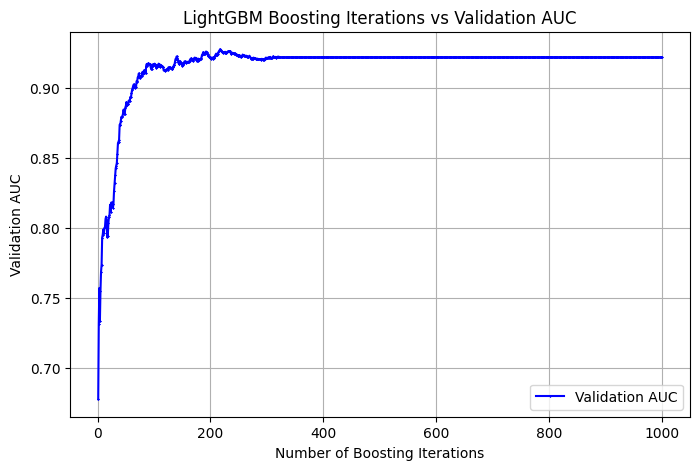

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score

dval = lgb.Dataset(X_test, label=y_test, free_raw_data=True)
# Define the range of estimators


evals_result = {}  # Stores validation results
eval_callback = lgb.record_evaluation(evals_result)  # Callback to record results

model = lgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,  # Maximum boosting rounds
    valid_sets=[dval],
    valid_names=["Validation"],
    callbacks=[eval_callback],  # Stores metrics
    # early_stopping_rounds=10,  # Stop if no improvement in 10 rounds
    # verbose_eval=False  # Suppress logging
)

# Extract validation AUC scores
iterations = list(range(1, len(evals_result["Validation"]["auc"]) + 1))
validation_auc = evals_result["Validation"]["auc"]

# Plot Results
plt.figure(figsize=(8, 5))
plt.plot(
    iterations,
    validation_auc,
    marker="x",
    linestyle="-",
    color="b",
    label="Validation AUC",
    markersize=1,
)
plt.xlabel("Number of Boosting Iterations")
plt.ylabel("Validation AUC")
plt.title("LightGBM Boosting Iterations vs Validation AUC")
plt.legend()
plt.grid(True)
plt.show()

dict_keys(['valid auc-mean', 'valid auc-stdv'])


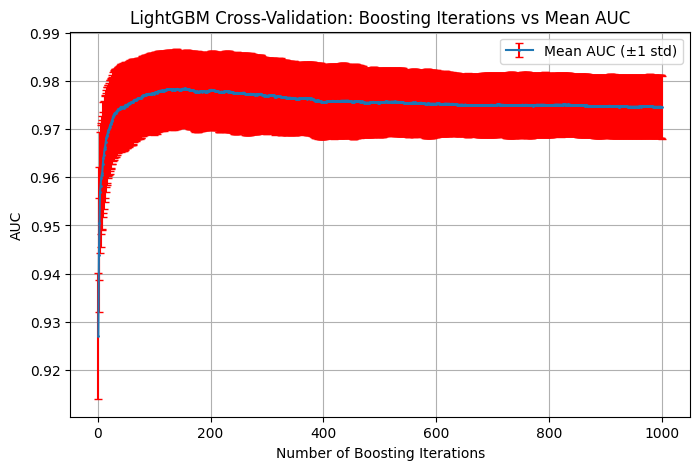

In [15]:
cv_results = lgb.cv(
    params,
    dtrain,
    num_boost_round=1000,  # Maximum number of boosting rounds
    nfold=5,  # Number of folds
    stratified=True,  # Stratified sampling for classification
    shuffle=True,  # Shuffle the data before splitting
    # early_stopping_rounds=10,   # Early stopping
    # verbose_eval=False,         # Suppress detailed logging
    seed=42,  # Reproducibility
)

# lgb.cv returns a dictionary containing the mean and standard deviation
# of the metric values across folds for each boosting iteration.
# Usually with metric='auc', you get:
# - cv_results["auc-mean"]
# - cv_results["auc-stdv"]

print(cv_results.keys())
# Extract the mean and standard deviation of the AUC across folds
mean_auc = cv_results["valid auc-mean"]
std_auc = cv_results["valid auc-stdv"]

# Create a list of iteration numbers
iterations = np.arange(1, len(mean_auc) + 1)

# Plot mean AUC vs boosting iterations (with error bars for standard deviation)
plt.figure(figsize=(8, 5))
plt.errorbar(
    iterations,
    mean_auc,
    yerr=std_auc,
    fmt="-o",
    ecolor="r",
    capsize=3,
    label="Mean AUC (±1 std)",
    markersize=1,
)
plt.xlabel("Number of Boosting Iterations")
plt.ylabel("AUC")
plt.title("LightGBM Cross-Validation: Boosting Iterations vs Mean AUC")
plt.grid(True)
plt.legend()
plt.show()

(16326,)
(16326,)


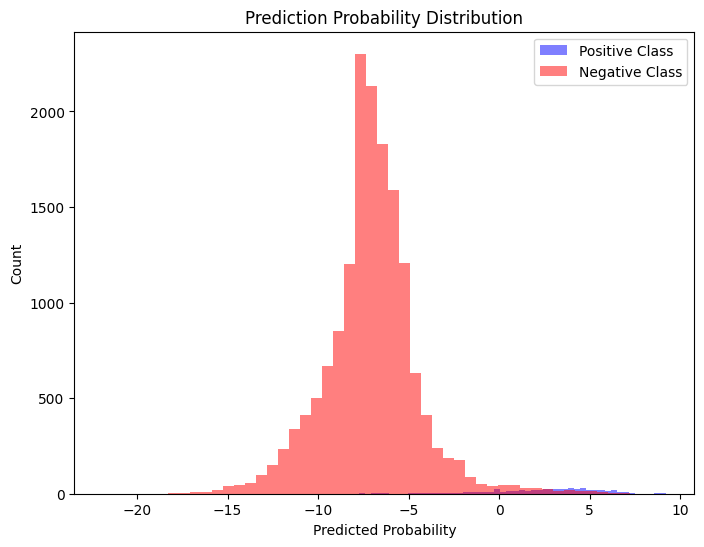

In [69]:
y_true = y_test
y_scores = y_test_pred_probs
print(y_scores.shape)
print(y_true.shape)
plt.figure(figsize=(8, 6))
plt.hist(
    y_scores[y_true == 1], bins=50, alpha=0.5, color="blue", label="Positive Class"
)
plt.hist(y_scores[y_true == 0], bins=50, alpha=0.5, color="red", label="Negative Class")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.title("Prediction Probability Distribution")
plt.legend()
plt.show()


In [11]:
import plotly.graph_objects as go
import numpy as np

# Sample data (Replace y_true and y_scores with actual data)
y_true = y_test
y_scores = y_test_pred_probs

# Separate probabilities by class
positive_scores = y_scores[y_true == 1]
negative_scores = y_scores[y_true == 0]

# Create histogram traces
fig = go.Figure()
fig.add_trace(
    go.Histogram(
        x=positive_scores,
        nbinsx=50,
        opacity=0.5,
        name="Positive Class",
        marker_color="blue",
    )
)
fig.add_trace(
    go.Histogram(
        x=negative_scores,
        nbinsx=50,
        opacity=0.5,
        name="Negative Class",
        marker_color="red",
    )
)

# Layout settings
fig.update_layout(
    title="Prediction Probability Distribution",
    xaxis_title="Predicted Probability",
    yaxis_title="Count",
    barmode="overlay",  # Overlay bars
    legend=dict(x=0.75, y=1),
)

fig.write_html("accurate_prediction_probability_histogram.html")
fig.show()

LinAlgError: Last 2 dimensions of the array must be square

In [7]:
# GET MODEL THRESHOLD FOR CHOSEN TPR, MAKE PREDICTIONS

from eppi_text_classification.predict import (
    get_raw_threshold,
    raw_threshold_predict,
)

threshold = get_raw_threshold(model, X_test, y_test, target_tpr=0.9)

y_test_pred = raw_threshold_predict(model, X_test, threshold)
y_train_pred = raw_threshold_predict(model, X_train, threshold)

In [8]:
from eppi_text_classification import binary_train_valid_confusion_plotly

binary_train_valid_confusion_plotly(
    y_train,
    y_train_pred,
    y_test,
    y_test_pred,
    postive_label="Included",
    negative_label="Excluded",
)

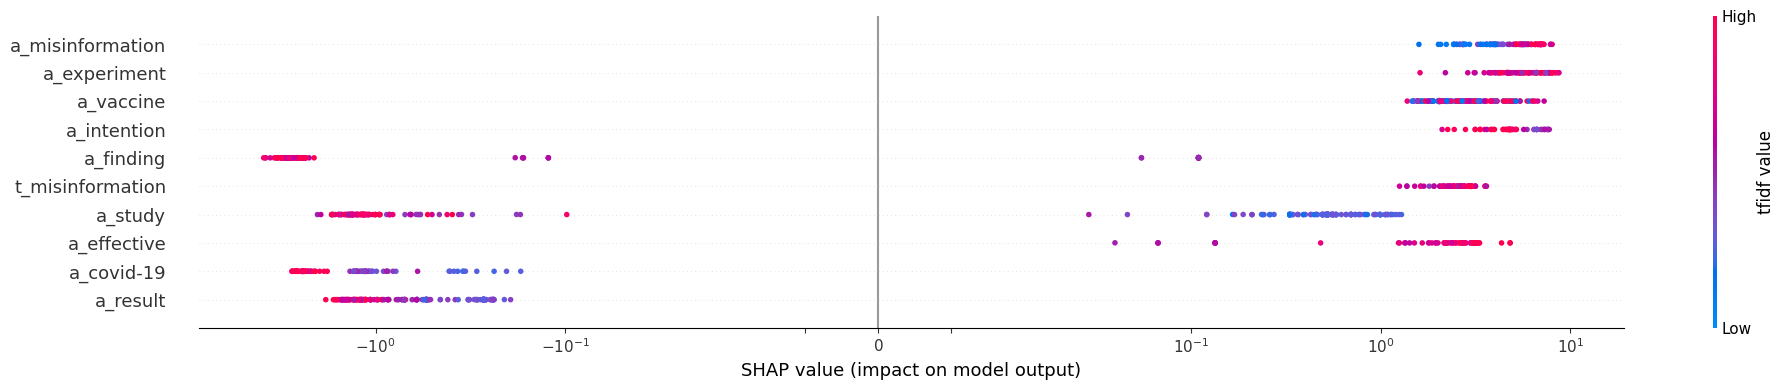

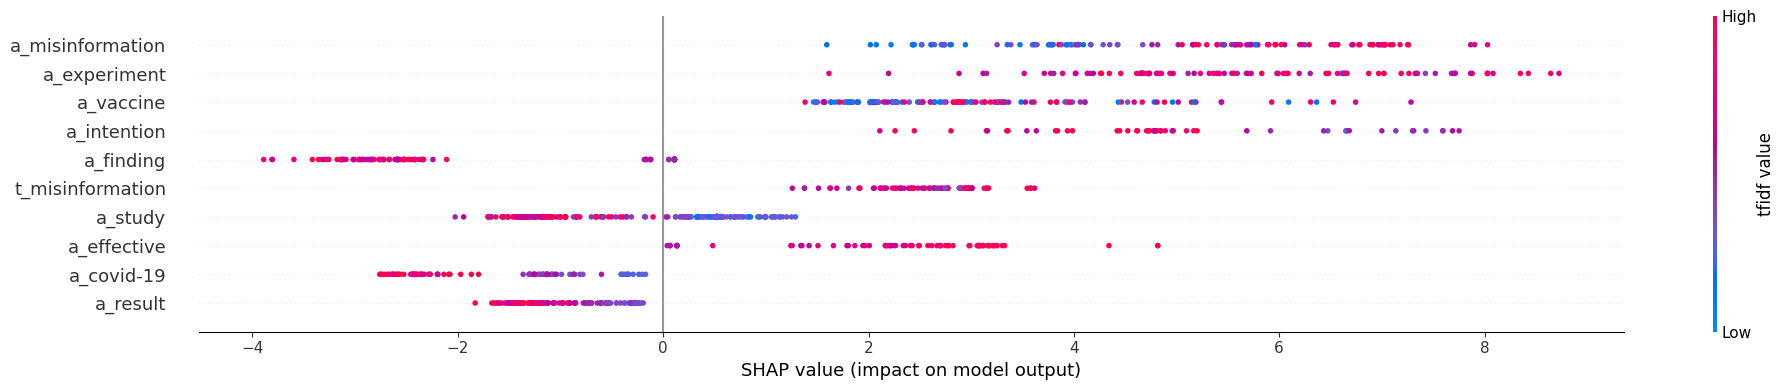

In [9]:
from eppi_text_classification import ShapPlotter

shap_plotter = ShapPlotter(
    model,
    X_test,
    feature_names,
)
dot_plot = shap_plotter.dot_plot(num_display=10)
dot_plot.show()
dot_plot = shap_plotter.dot_plot(num_display=10, log_scale=False)
dot_plot.show()
bar_plot = shap_plotter.bar_chart()

Truth: 0
Prediction: [0]
Shap value: -20.176006658783766
Prediction score: [-20.17600658]


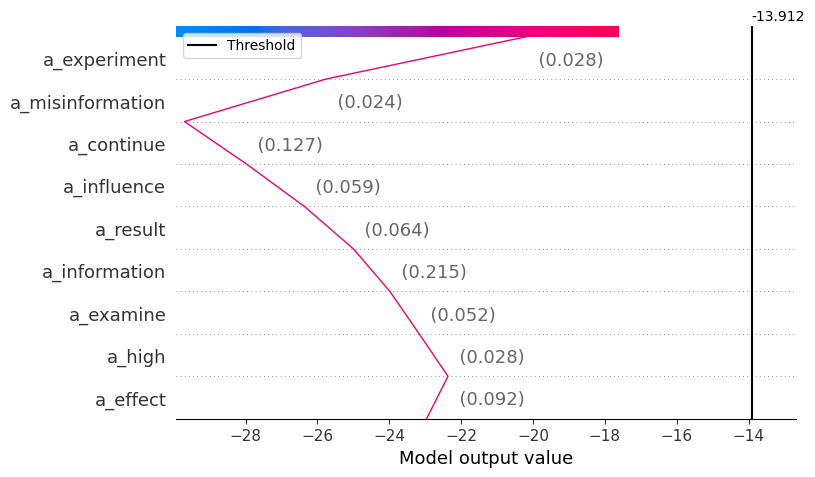

Truth: 0
Prediction: [1]
Shap value: -4.616689011304292
Prediction score: [-4.6166887]


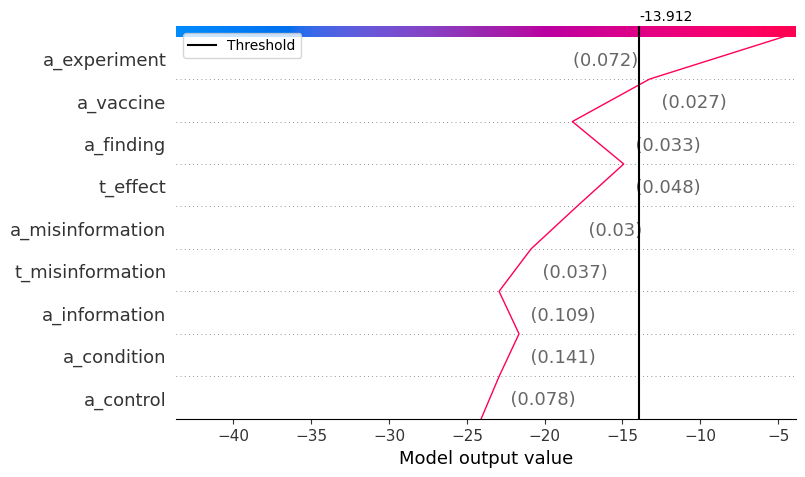

Truth: 0
Prediction: [0]
Shap value: -26.435449810548338
Prediction score: [-26.43544985]


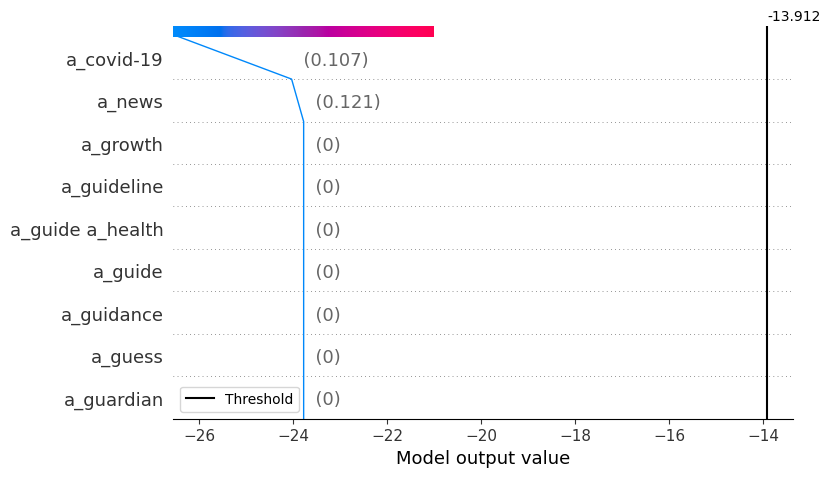

Truth: 0
Prediction: [0]
Shap value: -25.180047043448898
Prediction score: [-25.18004709]


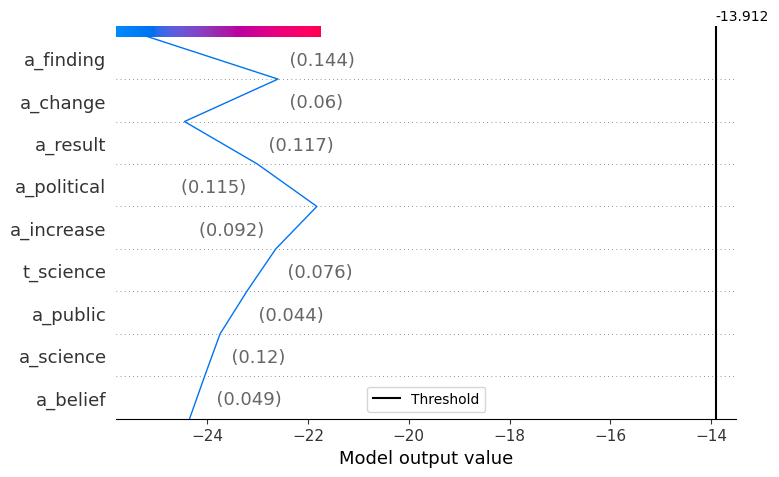

Truth: 0
Prediction: [0]
Shap value: -14.584450788645658
Prediction score: [-14.58445081]


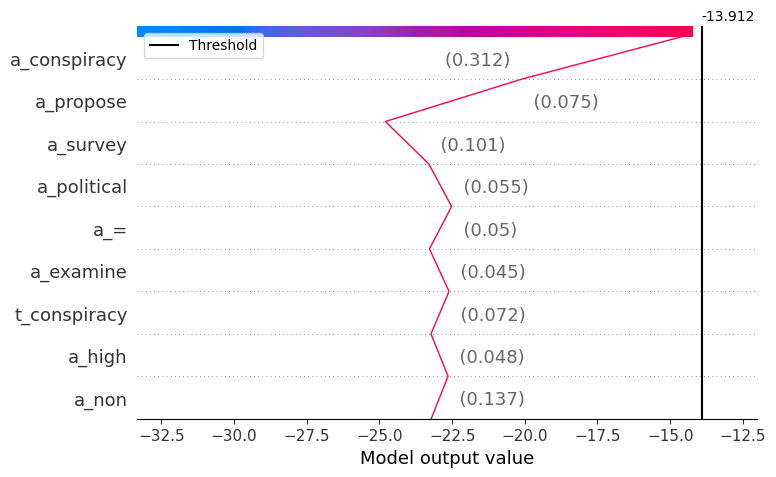

In [10]:
import numpy as np

shap_plotter = ShapPlotter(model, X_test[0:10], feature_names)

for i in range(5):
    print(f"Truth: {y_test[i]}")
    print(f"Prediction: {raw_threshold_predict(model, X_test[i], threshold)}")
    print(
        f"Shap value: {shap_plotter.shap_values[i].sum() + shap_plotter.expected_value}"
    )
    print(f"Prediction score: {predict_scores(model, X_test[i])}")
    decision_plot = shap_plotter.single_decision_plot(
        threshold=threshold, index=i, num_display=10, log_scale=False
    )
    decision_plot.show()